In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 20})
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [ ]:
# Set the diagonal element of the bilinear matrix to be always zero

class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        if bias:
            # Use register_buffer to make bias a non-trainable fixed value (-70)
            self.register_buffer('bias', torch.tensor(-70.0, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        # if bias:
        #     self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        # if self.bias is not None:
        #     nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0
                
        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [3]:
# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 200)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

In [4]:
data = np.load('/data/mjy/Yeqiang/subthres_coarse_data.npz')

input_data = data['coarse_ip_m_array']
output_data = data['coarse_v_array']

train_input = torch.tensor(input_data[:1000], dtype=torch.float32).to(device)
train_output = torch.tensor(output_data[:1000], dtype=torch.float32).to(device)
test_input = torch.tensor(input_data[1000:], dtype=torch.float32).to(device)
test_output = torch.tensor(output_data[1000:], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_input, train_output)
test_dataset = TimeSeriesDataset(test_input, test_output)

In [62]:
# load the data
# with open('/data/mjy/Yeqiang/purePas_data.json', 'r', encoding='utf-8') as file:
#     data = json.load(file)

# input_data = data['ip_m_list']
# output_data = data['v_list']

# train_input = torch.tensor(input_data[:1000], dtype=torch.float32).to(device)
# train_output = torch.tensor(output_data[:1000], dtype=torch.float32).to(device)
# test_input = torch.tensor(input_data[1000:], dtype=torch.float32).to(device)
# test_output = torch.tensor(output_data[1000:], dtype=torch.float32).to(device)

# train_dataset = TimeSeriesDataset(train_input, train_output)
# test_dataset = TimeSeriesDataset(test_input, test_output)

# print('Data loaded')

In [5]:
num_dimensions = train_input.size()[1]
time_dur = train_input.size()[2]
print(f'Number of synapses is: {num_dimensions}')
print(f'Time duration is: {int(time_dur-1)} ms')

Number of synapses is: 9
Time duration is: 5000 ms


In [24]:
# 设置随机数种子
manual_seed = torch.seed()  # 获取当前随机数种子
torch.manual_seed(manual_seed)  # 使用该种子进行随机数生成

print(f"Random seed used: {manual_seed}")

Random seed used: 15688232066040657555


In [6]:
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device=device)
print('Model created')
print('Parameters contained:')
for name, param in model.named_parameters():
    print(name, param.size(), param)

Model created
Parameters contained:
tau_rise torch.Size([9]) Parameter containing:
tensor([50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:6',
       requires_grad=True)
tau_decay torch.Size([9]) Parameter containing:
tensor([200., 200., 200., 200., 200., 200., 200., 200., 200.], device='cuda:6',
       requires_grad=True)
omega torch.Size([9]) Parameter containing:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:6',
       requires_grad=True)
bilinear.weight torch.Size([1, 9, 9]) Parameter containing:
tensor([[[ 0.0000, -0.1003,  0.3219, -0.2347, -0.3094,  0.0949,  0.0883,
           0.1362, -0.1659],
         [-0.1192,  0.0000,  0.3079, -0.2372, -0.0777,  0.1408, -0.0434,
          -0.0558, -0.2607],
         [ 0.2845,  0.0175,  0.0000, -0.1317,  0.0711,  0.0179,  0.2509,
           0.1769,  0.1409],
         [-0.2067,  0.2072,  0.3258,  0.0000,  0.2539, -0.2460,  0.1112,
          -0.2332, -0.0793],
         [-0.3001, -0.0648,  0.0357,  0.3295,  0.0000,  0.0338,

In [7]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device=device)
save_path = '/home/mjy/project/bilinear_network/parameters/model_coarse_cuda6_bs16_lr0.16_epochs1000.pth'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

/tmp/ipykernel_484018/3414475693.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path)


<All keys matched successfully>

In [8]:
print(model.state_dict())

OrderedDict([('tau_rise', tensor([ 35.5548,  44.4311,  65.5076,  62.9104, 144.6530,  75.9755,  39.7765,
         38.9891,  52.9364], device='cuda:6')), ('tau_decay', tensor([21.2526, 20.6759, 21.6847, 21.7734, 21.0837, 24.0534, 19.3128, 19.7631,
        19.5619], device='cuda:6')), ('omega', tensor([ 8.9024,  7.2771,  3.5392,  6.7958, -0.4848,  4.6583, -7.0652, -7.8685,
        -7.9356], device='cuda:6')), ('bilinear.weight', tensor([[[ 0.0000e+00, -2.2494e-01,  1.6467e-01, -5.1022e-03, -1.2770e+00,
          -1.7636e-01,  1.3641e-01, -1.4203e-01,  2.0778e-01],
         [ 2.4111e-01,  0.0000e+00,  8.6801e-02, -2.1549e-01, -1.7549e+00,
          -7.9163e-02, -2.2057e-01,  6.4596e-02, -1.5117e-01],
         [-7.0170e-02,  7.4423e-02,  0.0000e+00,  1.2945e-01, -5.0561e+00,
           3.1934e-01,  9.9338e-02,  2.1289e-01,  2.9698e-01],
         [ 4.2344e-02,  2.5617e-01,  6.2973e-02,  0.0000e+00, -2.5164e+00,
          -1.5580e-01,  1.9510e-01,  1.5059e-01,  6.5526e-02],
         [-1.0853e

In [9]:
output = model(train_input)

IndexError: Dimension specified as 0 but tensor has no dimensions

In [47]:
a = (output - train_output) ** 2
b = torch.mean(a, dim=1)
c = torch.var(train_output, dim=1)
c.size()
d = b / c
d.size()
# b[0], b[1]

torch.Size([1000])

In [38]:
error1 = torch.mean((output[0] - train_output[0]) ** 2)
print(f'Error1 is: {error1}')
error2 = torch.mean((output[1] - train_output[1]) ** 2)
print(f'Error2 is: {error2}')
loss = nn.MSELoss()
loss(output, train_output)

Error1 is: 0.686859130859375
Error2 is: 0.6110952496528625


tensor(0.6776, device='cuda:5', grad_fn=<MseLossBackward0>)

In [68]:
def variance_explained(output, target):
    error = torch.mean((output - target) ** 2, dim=1)
    variance = torch.var(target, dim=1)
    return 1 - error / variance

In [69]:
ve = variance_explained(output, train_output)

In [72]:
error1 = torch.mean((output - train_output) ** 2, dim=1)

In [77]:
np.argmin(error1.cpu().detach().numpy())

716

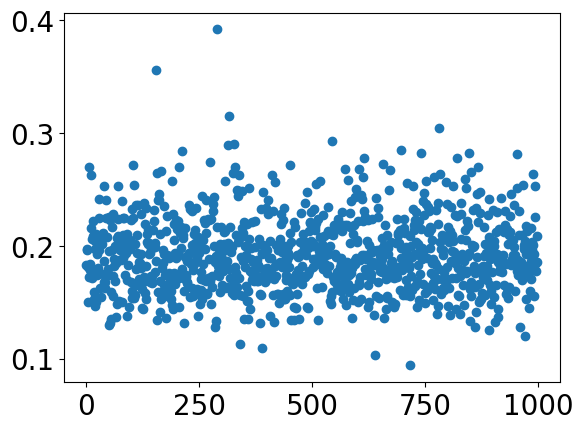

In [73]:
plt.scatter(np.arange(len(ve)), error1.cpu().detach().numpy())

In [49]:
ve = variance_explained(output, train_output)

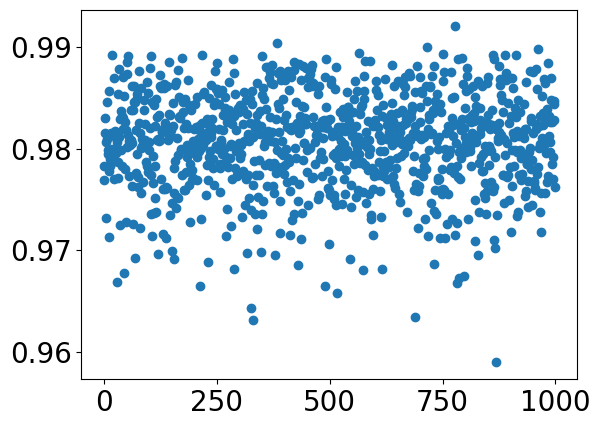

In [84]:
plt.scatter(np.arange(len(ve)), ve.cpu().detach().numpy()+0.01)

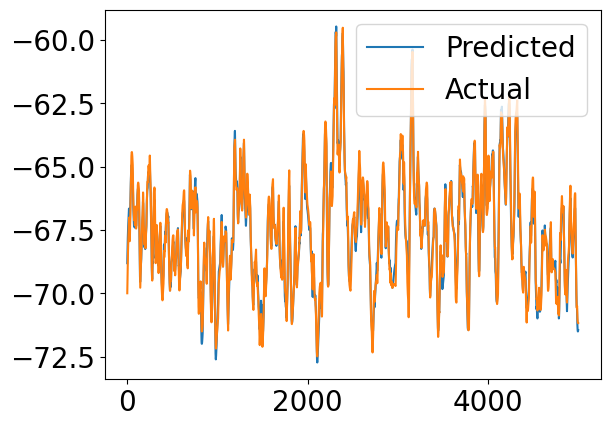

In [78]:
plt.plot(output[716].detach().cpu().numpy(), label='Predicted')
plt.plot(train_output[716].detach().cpu().numpy(), label='Actual')
plt.legend()

In [80]:
output_test = model(test_input)
ve_test = variance_explained(output_test, test_output)
error1_test = torch.mean((output_test - test_output) ** 2, dim=1)

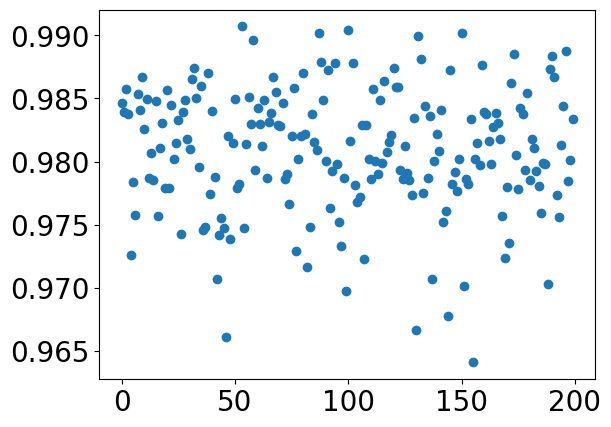

In [85]:
plt.scatter(np.arange(len(ve_test)), ve_test.cpu().detach().numpy()+0.01)

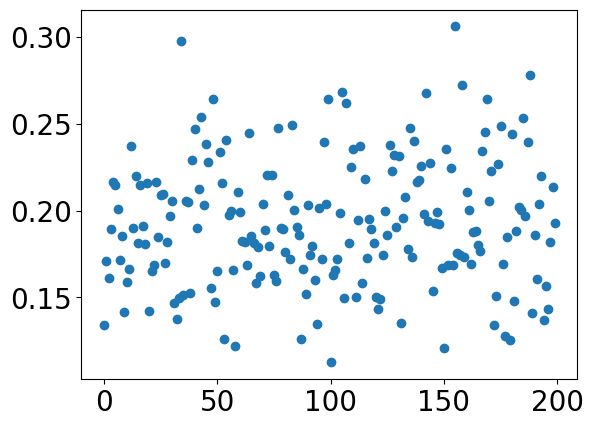

In [82]:
plt.scatter(np.arange(len(ve_test)), error1_test.cpu().detach().numpy())

In [79]:
ve[716]

tensor(0.9800, device='cuda:6', grad_fn=<SelectBackward0>)

In [27]:
tau_rise = model.tau_rise.detach().cpu().unsqueeze(1)
tau_decay = model.tau_decay.detach().cpu().unsqueeze(1)
omega = model.omega.detach().cpu().unsqueeze(1)
T = torch.arange(time_dur)
kernels = omega * (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)

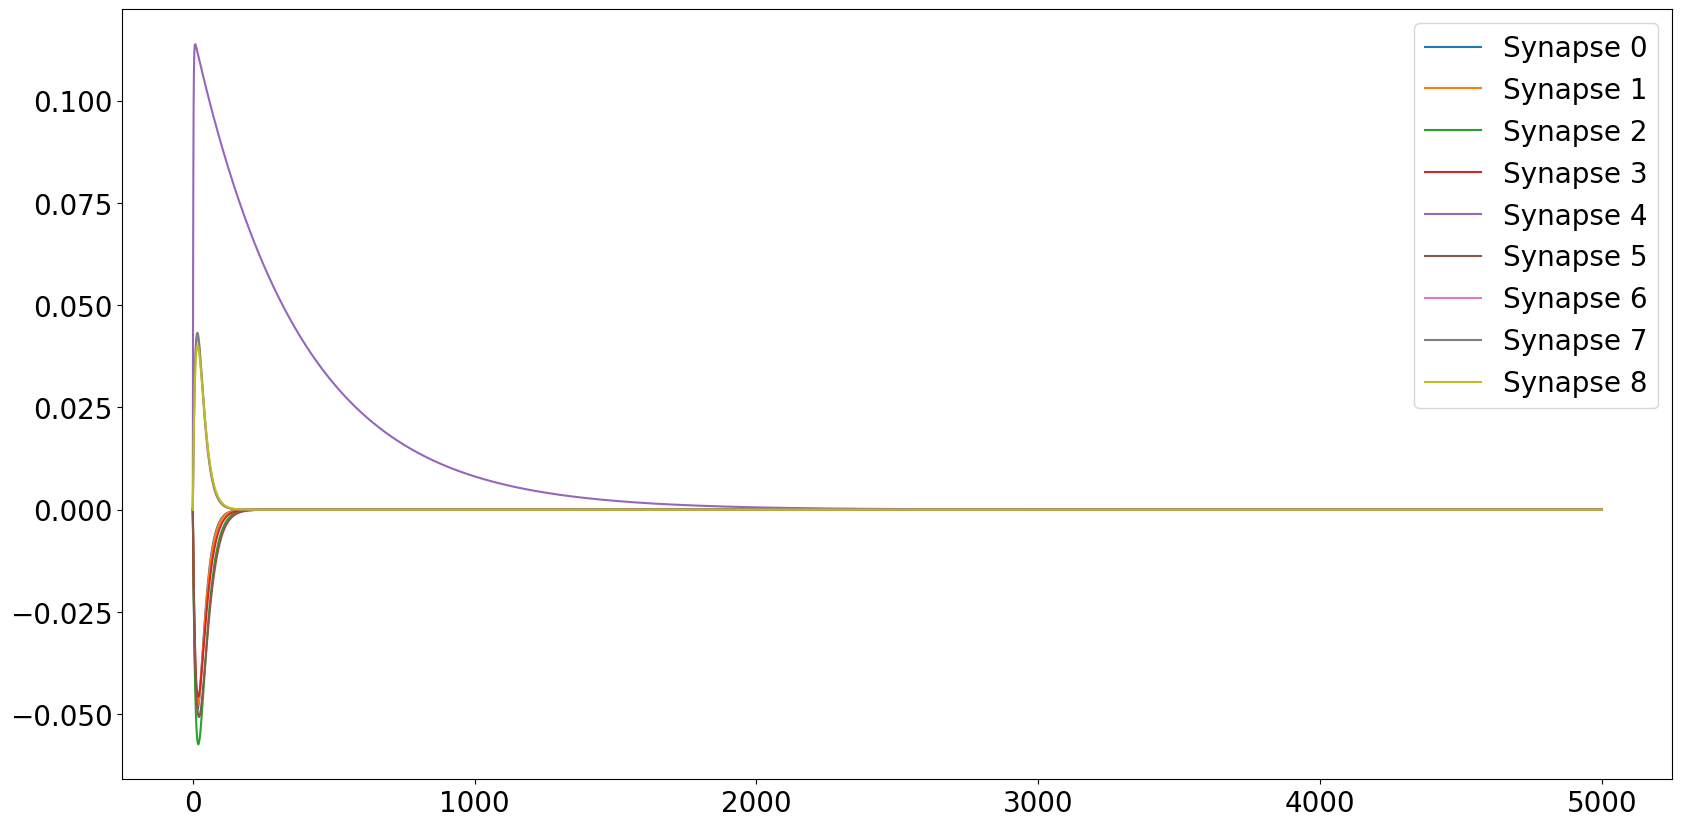

In [76]:
plt.figure(figsize=(20, 10))
for i in range(num_dimensions):
    plt.plot(kernels[i], label=f'Synapse {i}')
plt.legend()

In [26]:
tau_rise.size()

torch.Size([9])

In [ ]:
def create_kernels(self):
    T = torch.arange(self.time_dur).to(self.device)
    N = self.num_dimensions
    net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
    net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
    net_omega = self.omega.unsqueeze(1)  # (N, 1)

    kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
    return kernels.unsqueeze(1)

In [9]:
for name, param in model.named_parameters():
    print(name, param)

tau_rise Parameter containing:
tensor([50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:0',
       requires_grad=True)
tau_decay Parameter containing:
tensor([200., 200., 200., 200., 200., 200., 200., 200., 200.], device='cuda:0',
       requires_grad=True)
omega Parameter containing:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:0',
       requires_grad=True)
bilinear.weight Parameter containing:
tensor([[[ 0.0000, -0.3316, -0.3182,  0.0299,  0.2506, -0.3299,  0.1324,
           0.1751, -0.1339],
         [-0.0776,  0.0000, -0.2158,  0.1603,  0.1476, -0.1687,  0.0200,
          -0.2974,  0.0047],
         [-0.0597, -0.1572,  0.0000,  0.2618, -0.0364,  0.2074, -0.2203,
          -0.2988, -0.1990],
         [-0.0580, -0.0904,  0.2494,  0.0000,  0.3072, -0.0671,  0.2432,
           0.0054, -0.0073],
         [-0.2382,  0.0129,  0.0888,  0.0365,  0.0000,  0.0765,  0.2413,
           0.1686, -0.1877],
         [-0.2212,  0.2053, -0.1252, -0.3006,  0.1689,  0.0000, -0.

In [25]:
for i in range(100):
    output = model(train_input)


KeyboardInterrupt: 

In [22]:
model.state_dict()

OrderedDict([('tau_rise',
              tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:0')),
             ('tau_decay',
              tensor([200., 200., 200., 200., 200., 200., 200., 200., 200., 200.],
                     device='cuda:0')),
             ('omega',
              tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:0')),
             ('bilinear.weight',
              tensor([[[ 0.0000, -0.2254,  0.1184,  0.2038,  0.3019,  0.2720,  0.2319,
                         0.0459, -0.1433, -0.0647],
                       [ 0.1323,  0.0000,  0.1136,  0.0253, -0.0275, -0.1619,  0.2190,
                         0.2857,  0.1440, -0.0547],
                       [ 0.0367, -0.0132,  0.0000,  0.0780,  0.1799,  0.2710, -0.0310,
                        -0.0201,  0.0927,  0.0697],
                       [-0.1929,  0.2172,  0.1445,  0.0000,  0.0626,  0.1848, -0.1183,
                         0.0790,  0.2624, -0.1550],
                       [ 0.0208,  0.19

In [16]:
batch_size = 64
learning_rate = 0.01
num_epochs = 500
save_path = '/home/mjy/project/bilinear_network/parameters/model.pth'
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MSE Loss
criterion = nn.MSELoss()

# =Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# 记录训练开始时间
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录每个 epoch 开始时间

    model.train()  
    running_loss = 0.0
    for batch_data, batch_targets in train_loader:
        optimizer.zero_grad()  

        # 前向传播
        output = model(batch_data)

        # 计算损失
        loss = criterion(output, batch_targets)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item() * batch_data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    epoch_end_time = time.time()  # 记录每个 epoch 结束时间
    epoch_time = epoch_end_time - epoch_start_time  # 计算每个 epoch 耗时

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f} seconds')

    # 每十个 epoch 计算一次测试误差
    if (epoch + 1) % 10 == 0:
        model.eval()  # 进入评估模式
        test_loss = 0.0

        with torch.no_grad():
            for batch_data, batch_targets in test_loader:
                # 前向传播
                output = model(batch_data)

                # 计算损失
                loss = criterion(output, batch_targets)
                test_loss += loss.item() * batch_data.size(0)

        test_loss /= len(test_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')

# 记录训练结束时间
end_time = time.time()
total_time = end_time - start_time

# 保存模型参数
torch.save(model.state_dict(), save_path)
print("Training complete and model saved.")
print(f'Total training time: {total_time:.2f} seconds')


Epoch [1/500], Loss: 5598.6219, Time: 1.28 seconds
Epoch [2/500], Loss: 1484.1125, Time: 0.96 seconds
Epoch [3/500], Loss: 1042.6373, Time: 0.96 seconds
Epoch [4/500], Loss: 874.8549, Time: 0.96 seconds
Epoch [5/500], Loss: 780.1598, Time: 0.96 seconds


KeyboardInterrupt: 

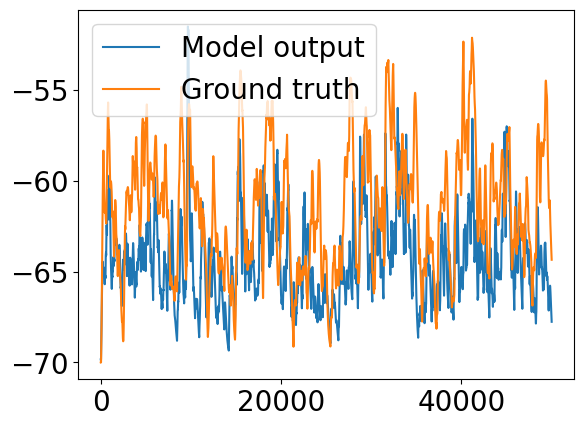

In [57]:
plt.plot(y.cpu().detach().numpy()[0]-70, label='Model output')
plt.plot(train_output[0].cpu().detach().numpy(), label='Ground truth')
plt.legend()

In [188]:
batch_size = 32
train_dataset = TimeSeriesDataset(train_input, train_output)
test_dataset = TimeSeriesDataset(test_input, test_output)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [191]:
train_input.size()[1]

9

In [192]:
num_dimensions = train_input.size()[1]
time_dur = train_input.size()[2]

# Define model
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur)

# MSE Loss
criterion = nn.MSELoss()

# Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # 进入训练模式

    running_loss = 0.0
    for batch_data, batch_targets in train_loader:
        optimizer.zero_grad()  # 清除之前的梯度

        # 前向传播
        output = model(batch_data)

        # 计算损失
        loss = criterion(output, batch_targets)
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新参数

        running_loss += loss.item() * batch_data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete.")

# 测试循环
model.eval()  # 进入评估模式
test_loss = 0.0

with torch.no_grad():
    for batch_data, batch_targets in test_loader:
        # 前向传播
        output = model(batch_data)

        # 计算损失
        loss = criterion(output, batch_targets)
        test_loss += loss.item() * batch_data.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

In [179]:
test_output.size()

torch.Size([200, 50001])

In [176]:
train_input[0, 2].sum()

tensor(100.)

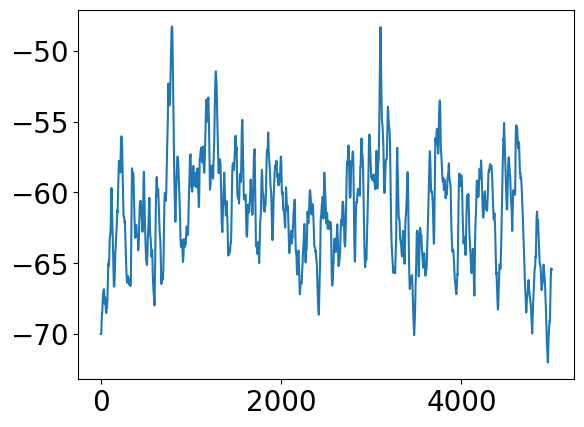

In [32]:
plt.plot(test_output[0,::10].numpy())

In [89]:
# 损失函数：MSE Loss
num_dimensions = 5  # Example: number of synapses
time_dur = 100      # Example: time duration

# 初始化模型
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device=device)
print(model.bilinear.weight)

criterion = nn.MSELoss()

# 优化器：Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 模拟数据
batch_size = 32
input_data = torch.randn(batch_size, num_dimensions, time_dur).to(device)  # 模拟输入 (batch_size, N_synapse, time_dur)
target_data = torch.randn(batch_size, time_dur).to(device)  # 目标时间序列 (batch_size, time_dur)

# 训练循环
num_epochs = 100  # 设置训练轮数

for epoch in range(num_epochs):
    model.train()  # 进入训练模式

    # 前向传播
    output = model(input_data)

    # 计算损失
    loss = criterion(output, target_data)

    # 反向传播
    optimizer.zero_grad()  # 清除之前的梯度
    loss.backward()        # 计算当前的梯度
    optimizer.step()       # 更新模型参数
    # print(model.bilinear.weight)
    # 打印每个epoch的损失
    if (epoch + 1) % 10 == 0:  # 每隔10个epoch打印一次损失
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")
print(model.bilinear.weight)

Parameter containing:
tensor([[[ 0.0000,  0.2637,  0.2059,  0.2274,  0.0931],
         [-0.1589,  0.0000, -0.3766,  0.3765, -0.3182],
         [-0.3388, -0.2311,  0.0000, -0.3135, -0.3663],
         [-0.3937,  0.2952, -0.1303,  0.0000, -0.4343],
         [-0.3403,  0.0431, -0.0813,  0.1964,  0.0000]]], device='cuda:0',
       requires_grad=True)
Epoch [10/100], Loss: 2983.2917
Epoch [20/100], Loss: 2625.3420
Epoch [30/100], Loss: 2309.2964
Epoch [40/100], Loss: 2033.3881
Epoch [50/100], Loss: 1794.1119
Epoch [60/100], Loss: 1587.2773
Epoch [70/100], Loss: 1408.7137
Epoch [80/100], Loss: 1254.6096
Epoch [90/100], Loss: 1121.6210
Epoch [100/100], Loss: 1006.8556
Training complete.
Parameter containing:
tensor([[[ 2.9406e-04,  1.8818e-01,  1.2699e-01,  3.1112e-01,  1.7360e-01],
         [-2.3435e-01, -1.2176e-03, -2.8630e-01,  2.8887e-01, -4.0082e-01],
         [-4.1775e-01, -1.4081e-01, -8.1439e-04, -2.2765e-01, -2.8122e-01],
         [-3.0990e-01,  2.0761e-01, -4.4455e-02, -1.0530e-03, 

In [90]:
# model = DBNN(2, 100)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Shape: {param.shape}")

Parameter: tau_rise, Shape: torch.Size([5])
Parameter: tau_decay, Shape: torch.Size([5])
Parameter: omega, Shape: torch.Size([5])
Parameter: bilinear.weight, Shape: torch.Size([1, 5, 5])
Parameter: bilinear.bias, Shape: torch.Size([1])


In [92]:
print(model.tau_decay)

Parameter containing:
tensor([199.9467, 199.9190, 199.9204, 199.9199, 199.9380], device='cuda:0',
       requires_grad=True)


In [86]:
model.bilinear.weight.grad

tensor([[[ 176.0680,   59.7977, -107.8064,  -50.3603,   91.5052],
         [  59.7977,  559.3868, -700.8064,   34.5523,  417.1030],
         [-107.8064, -700.8065, -223.6179,   81.3571, -427.4105],
         [ -50.3603,   34.5523,   81.3572,  424.0225, -188.2439],
         [  91.5052,  417.1030, -427.4105, -188.2439,  713.2454]]],
       device='cuda:0')

In [154]:
print("Gradients of the parameters:")
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name}: {param.grad}')
    else:
        print(f'{name}: No gradient')


Gradients of the parameters:
tau_rise: tensor([-0.3780, -0.8984, -0.4207, -0.9795, -1.2971])
tau_decay: tensor([0.2694, 0.6199, 0.2686, 0.6877, 0.9944])
omega: tensor([ 7.6376, 17.8632,  8.2008, 19.3363, 27.0315])
bilinear.weight: tensor([[[  0.5550,  -1.2223,   5.5750,   0.0204,   0.2067],
         [ -1.2223,  -6.0159,   4.0916, -12.0258, -14.1559],
         [  5.5750,   4.0916,  -5.5730,  -5.6885,   1.5274],
         [  0.0204, -12.0258,  -5.6885,  -2.9486, -19.3934],
         [  0.2067, -14.1559,   1.5274, -19.3934,  -1.3774]]])
bilinear.bias: tensor([-0.7226])


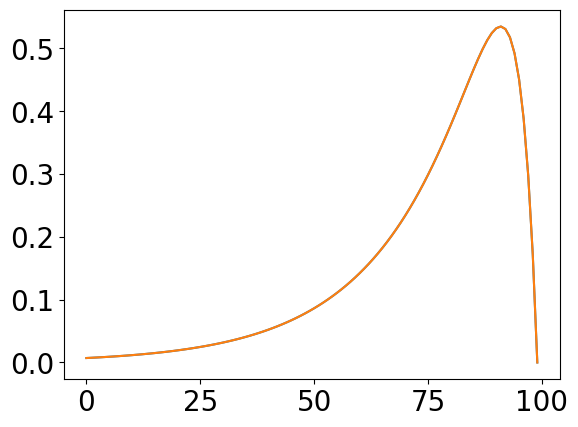

In [89]:
a = model.conv.weight
plt.plot(a[0,0].detach().numpy())
plt.plot(a[1,0].detach().numpy())

In [101]:
# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions) * 5)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions) * 20)
        self.omega = nn.Parameter(torch.ones(num_dimensions))

        # self.kernel = create_kernels(self.tau_rise, self.tau_decay, self.omega, time_dur)
        # self.kernel_flipped = torch.flip(self.kernel, dims=[1]).unsqueeze(1)
        self.kernel = self.create_kernels()  # 初始计算
        self.kernel_flipped = torch.flip(self.kernel, dims=[1]).unsqueeze(1)
        
        self.conv = nn.Conv1d(self.num_dimensions, self.num_dimensions, kernel_size=self.time_dur, padding=self.time_dur - 1, groups=self.num_dimensions, bias=False)
        
        # Set the weights of the convolution layer
        with torch.no_grad():
            # self.conv.weight = nn.Parameter(self.kernel_flipped)
            self.conv.weight.copy_(self.kernel_flipped)  # Use copy_ to avoid breaking the computation graph

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1)

    def create_kernels(self):
        T = torch.arange(self.time_dur)
        N = self.num_dimensions
        tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        omega = self.omega.unsqueeze(1)  # (N, 1)

        y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)  # (N, T)
        y = y * omega  # Apply weight omega
        return y
        
    def forward(self, x):
        self.kernel = self.create_kernels()
        self.kernel_flipped = torch.flip(self.kernel, dims=[1]).unsqueeze(1)
        
        # Update the convolution layer weights
        # with torch.no_grad():
            # self.conv.weight = nn.Parameter(self.kernel_flipped)
        self.conv.weight.copy_(self.kernel_flipped)
        # # Update the kernel based on trainable tau_rise, tau_decay, and omega
        # self.kernel = create_kernels(self.tau_rise, self.tau_decay, self.omega, self.time_dur)
        # self.kernel_flipped = torch.flip(self.kernel, dims=[1]).unsqueeze(1)
        
        # # Update the convolution layer weights
        # with torch.no_grad():
        #     self.conv.weight = nn.Parameter(self.kernel_flipped)

        y = self.conv(x)[:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)